In [ ]:
!./setup.sh

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from typing import Tuple
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2
from scripts.lib import create_df, img_to_matrix, clip_img, compose

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data files into Datasets

In [2]:
TRAIN_PATH = "../data/real_vs_fake/real-vs-fake/train/"
TEST_PATH = "../data/real_vs_fake/real-vs-fake/test/"
VAL_PATH = "../data/real_vs_fake/real-vs-fake/valid/"

In [3]:
train_df = create_df(TRAIN_PATH)
test_df = create_df(TEST_PATH)
val_df = create_df(VAL_PATH)

train_df.shape, test_df.shape, val_df.shape

((100000, 2), (20000, 2), (20000, 2))

In [26]:
class FacesDataset(Dataset):
    def __init__(self, data: pl.DataFrame, path: str) -> None:
        self.data = data
        self.path = path
    
    def __len__(self) -> int:
        return self.data.shape[0]
    
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        data = self.data.slice(idx, 1)
        face, label = data['file'].item(), data['label'].item()
        path = self.path + ('fake/' if label == 0 else 'real/')
        img = compose(img_to_matrix, clip_img)(path + face)
        return img, label

In [27]:
train_loader = DataLoader(FacesDataset(train_df, TRAIN_PATH), shuffle=True, batch_size=64)
val_loader = DataLoader(FacesDataset(val_df, VAL_PATH), batch_size=64)
test_loader = DataLoader(FacesDataset(test_df, TEST_PATH), batch_size=64)

len(train_loader), len(val_loader), len(test_loader)

(1563, 313, 313)

In [28]:
faces, labels = next(iter(train_loader))

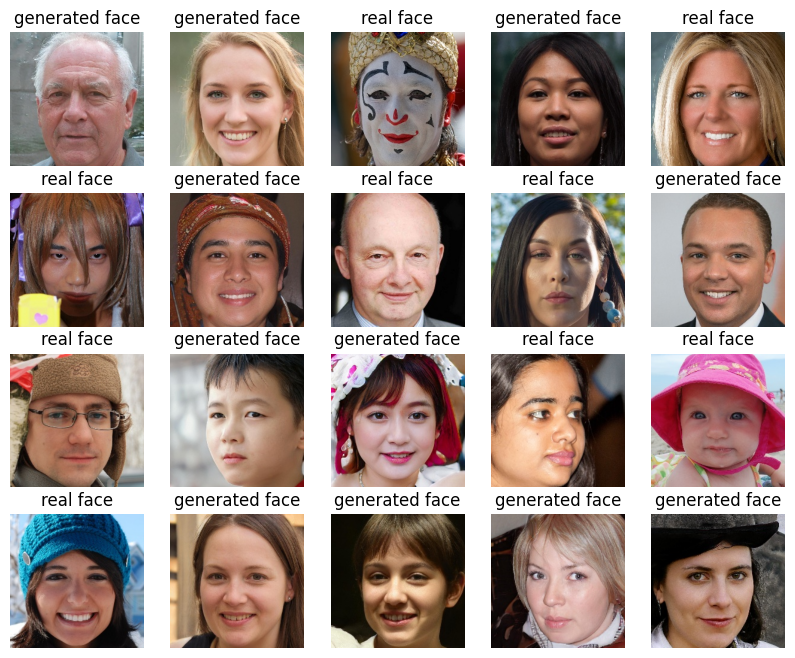

In [29]:
w, h = 8, 8
fig = plt.figure(figsize=(10, 8))
columns, rows = 5, 4

faces, labels = next(iter(train_loader))

for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.title("generated face" if labels[i] == 0 else "real face")
    plt.imshow(faces[i].to(dtype=torch.uint8))
    plt.axis('off')

plt.show()